In [1]:
import sys
sys.path.append('./../src')

In [1776]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
import re
from importlib import reload
from pymongo import MongoClient
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from pprint import pprint

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set(color_codes=True)
plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)

## Downloading data from MongoDB ##

In [171]:
with open('../pickles/raw_gd_corpus.pickle', 'wb') as to_write:
    pickle.dump(gd_corpus, to_write)

In [172]:
with open('../pickles/raw_g3s_corpus.pickle', 'wb') as to_write:
    pickle.dump(gd_corpus, to_write)

In [1773]:
with open('../pickles/raw_combined_corpus.pickle', 'wb') as to_write:
    pickle.dump(combined_corpus, to_write)

In [69]:
client = MongoClient()
db = client.blogs
db.list_collection_names()

['g3s', 'gd']

In [ ]:
cursor = db.gd.find({}, {'_id': 0, 'text': 1})

In [1679]:
cursor = db.gd.find({}, {'_id': 0, 'title': 1, 'date': 1, 'num_notes': 1, 'unique_pageviews': 1,
                         'url': 1, 'text': 1})

In [1680]:
gd_metadata = [{'title': result['title'],
                'date': result['date'],
                'num_notes': result['num_notes'],
                'unique_pageviews': result['unique_pageviews'],
                'url': result['url']}
               for result in cursor]

In [1682]:
gd_metadata[-1]

{'title': 'Diary Entry #1',
 'date': 'March 1st, 2016',
 'num_notes': 10,
 'unique_pageviews': 381,
 'url': 'https://gaysiandiaries.com/post/140302789153/diary-entry-1'}

In [71]:
# Store all gd texts (queried from mongodb) in a list of strings 
gd_corpus = [result['text'] for result in cursor]    

In [72]:
cursor = db.g3s.find({}, {'_id': 0, 'text': 1})

In [1683]:
cursor = db.g3s.find({}, {'_id': 0, 'title': 1, 'date': 1, 'num_notes': 1, 'unique_pageviews': 1,
                         'url': 1, 'text': 1})

In [1684]:
g3s_metadata = [{'title': result['title'],
                 'date': result['date'],
                 'num_notes': result['num_notes'],
                 'unique_pageviews': result['unique_pageviews'],
                 'url': result['url']}
                for result in cursor]

In [1687]:
g3s_metadata[-1]

{'title': 'Follower Friday: gregasaurus',
 'date': 'Jan 8th, 2016',
 'num_notes': 16,
 'unique_pageviews': 11,
 'url': 'https://gaysianthirdspace.tumblr.com/post/136911555225/follower-friday-gregasaurus'}

In [1688]:
combined_metadata = gd_metadata + g3s_metadata

In [73]:
# Store all gd texts (queried from mongodb) in a list of strings 
g3s_corpus = [result['text'] for result in cursor]  

In [173]:
g3s_corpus[150]

'\n\nFollower Fridays is a series of profiles highlighting members of Gaysian Third Space to showcase the diversity of gaysians in the Community. This week’s featured member is @beat0t.\n\n\n\nWho are you?\n\n\n\nMy name is Bea. I’m a recent college graduate, co-founder of a dance company based in Philadelphia called D2D: Dare To Dance. \n\n\n\nWhere are you from?\n\n\n\nI was born and raised in the island of Leyte, Philippines. Lived there most of my life before moving to the States when I was 12.\n\n\n\nWhat do you do?\n\n\n\nI’m you’re typical post grad, looking to jump start their career. I also teach dance at a local dance studio in Philadelphia\n\n\n\nWhat are you passionate about?\n\n\n\nI truly love dancing and I want to use dance as an avenue to change the world, no matter how small that change may be. I am also passionate about my Pilipinx identity. Little by little, I’m learning more and more about being a Pilipinx, I fall more and more in love about my heritage and my ident

In [75]:
count_follower_fridays = 0
for text in g3s_corpus:
    if 'Follower Fridays' in text:
        count_follower_fridays += 1
count_follower_fridays

139

In [76]:
count_come_out = 0
for text in g3s_corpus:
    if 'come out' in text:
        count_come_out += 1
count_come_out

18

In [77]:
count_coming_out = 0
for text in g3s_corpus:
    if 'coming out' in text:
        count_coming_out += 1
count_coming_out

20

In [124]:
count_coming_out = 0
for text in gd_corpus:
    if 'coming out' in text:
        count_coming_out += 1
count_coming_out

6

In [1782]:
len(gd_corpus)
len(g3s_corpus)

34

342

In [1783]:
len(combined_corpus)

376

In [1770]:
combined_corpus = gd_corpus + g3s_corpus

## Text preprocessing ##

In [1231]:
# Removed 'out' from sklearn stop_words list since 'coming out' is an important term in LGBT texts
from sklearn.feature_extraction import text
custom_stop_words = text.ENGLISH_STOP_WORDS.difference({'out'})

In [1246]:
# Remove numbers from corpus
combined_corpus = [re.sub('\w*\d+\w*', '', text) for text in combined_corpus]

In [1247]:
# Change mother to mom and father to dad so words referring to parents are consistent
combined_corpus = [text.replace('mother', 'mom').replace('father', 'dad') for text in combined_corpus]

In [1235]:
nlp = spacy.load('en_core_web_sm')
# nlp.Defaults.stop_words.remove("out")

In [1236]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [1248]:
docs = list(nlp.pipe(combined_corpus))

In [1249]:
# Lemmatize all the docs so I get all words reduced to their dictionary (lemma) forms
lemmatized_docs = []
for doc in docs:
    # Don't lemmatize the word if it's a pronoun
    lemmatized_docs.append(' '.join([token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]))

In [1779]:
with open('../pickles/lemmatized_docs.pkl', 'wb') as to_write:
    pickle.dump(lemmatized_docs, to_write)

In [1777]:
sent_tokenize_docs = [sent_tokenize(doc) for doc in lemmatized_docs]

In [1778]:
sent_tokenize_docs[0]

['eight year ago , I live in flush and have recently learn the way of korean drumming .',
 'one day , I be recruit as a drummer to go to Washington , DC to march and raise awareness about immigration legislation .',
 'We leave New York City at around   am and get back in the evening .',
 'I have a habit of make stupid mistake that get me into a bit of trouble all the time .',
 'when I have be tired , hungry , cold , or thirsty , I have be even prone to unintentionally cause myself harm .',
 'that evening , I be tired as I be walk home alone after all the activity with the contingent .',
 'there be around   Black or Brown kid hang around that I have to pass by on my way home .',
 'I take a glance at them but avoid eye contact .',
 'what you should know at this point be that I be also trans and at that time I have a fraction of the confidence I have now .',
 'there be also no man in my life that have ever think to teach me how to physically conduct myself .',
 'maybe it be because these 

In [1774]:
print(lemmatized_docs[0])

eight year ago , I live in flush and have recently learn the way of korean drumming . one day , I be recruit as a drummer to go to Washington , DC to march and raise awareness about immigration legislation . We leave New York City at around   am and get back in the evening . 

 I have a habit of make stupid mistake that get me into a bit of trouble all the time . when I have be tired , hungry , cold , or thirsty , I have be even prone to unintentionally cause myself harm . that evening , I be tired as I be walk home alone after all the activity with the contingent . there be around   Black or Brown kid hang around that I have to pass by on my way home . I take a glance at them but avoid eye contact . 

 what you should know at this point be that I be also trans and at that time I have a fraction of the confidence I have now . there be also no man in my life that have ever think to teach me how to physically conduct myself . 

 maybe it be because these kid also need to assert themselve

## Testing CountVectorizer and TfidfVectorizer ##

In [1575]:
cv = CountVectorizer(stop_words=custom_stop_words, ngram_range=(1, 2), min_df=3, max_df=0.4)
cv_X = cv.fit_transform(lemmatized_docs).toarray()

In [1576]:
tfidf = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(1, 2), min_df=3, max_df=0.4)
tfidf_X = tfidf.fit_transform(lemmatized_docs).toarray()

In [1577]:
cv_X.shape
tfidf_X.shape

(376, 5424)

(376, 5424)

In [1578]:
cv_doc_word = pd.DataFrame(cv_X, columns=cv.get_feature_names())
tfidf_doc_word = pd.DataFrame(tfidf_X, columns=tfidf.get_feature_names())

In [1780]:
with open('../pickles/tfidf_doc_word_matrix.pkl', 'wb') as to_write:
    pickle.dump(tfidf_doc_word, to_write)

In [1579]:
cv_doc_word.head()

,aapi,abandon,abc,ability,able,able make,able meet,able travel,able work,abroad,abs,absence,absolute,absolutely,abuse,academia,academic,accent,accept,accept love,accept open,accept sexuality,acceptable,acceptance,access,accommodate,accompany,accomplish,accomplishment,accord,account,accountability,accountable,accumulate,accurately,accuse,achieve,achievement,acknowledge,acquaintance,act,act like,act way,acting,action,action speak,active,actively,activism,activist,activity,actor,actual,actually,actually like,actually quite,actually talk,actually tell,actually want,acutely,ad,adam,adapt,add,addict,addiction,addition,additional,address,address issue,adequate,adhere,adjust,admire,admission,admit,adolescent,adopt,adore,adult,adulthood,advantage,adventure,advertising,advice,advise,advisor,advocacy,advocate,aesthetic,affair,affect,affect community,affection,affectionate,affirm,affirmation,afford,affordable,afraid,african,african american,afterlife,afternoon,afterward,age,age gay,agency,agenda,aggression,ago,agree,agree disagree,aha,ahead,aids,aim,air,airport,aisle,aka,akin,alarm,albeit,alcohol,alex,align,alive,alliance,allow,allow share,allow travel,ally,alostfish,alternate,alternative,altogether,amateur,amazing,amazing friend,ambition,america,american,american bear,american community,american culture,american family,american gay,american grow,american history,american male,american man,american student,americanize,americans,amusement,analysis,analyst,analyze,ancestor,ancestral,ancient,andrew,andy,anecdote,angel,angeles,anger,angle,angry,anguish,animal,animation,anime,anniversary,announce,annoyed,annoying,annual,anonymous,answer,answer question,antagonize,anthony,anti,anticipation,antonio,anxiety,anxious,anybody,anymore,anymore know,anyways,apart,apartment,api,api community,api equality,apologetic,apologize,apology,app,app like,apparently,appeal,appear,appearance,apple,application,apply,appreciate,appreciation,approach,approach date,appropriate,approve,april,architect,architecture,arduous,area,area passionate,arguably,argue,argument,arise,arm,army,arrange,arrangement,arrival,arrive,art,art form,art passionate,article,articulate,artist,artistic,ashamed,ashamed sexuality,asia,asian,asian america,asian american,asian americans,asian asian,asian community,asian country,asian culture,asian date,asian ethnicity,asian friend,asian gay,asian guy,asian identity,asian male,asian man,asian pacific,asian parent,asian people,asian pride,asian student,asian white,asians,asians asian,asians date,aside,ask,ask boyfriend,ask gay,ask help,ask know,ask like,ask mom,ask question,ask want,asleep,aspect,aspiration,aspire,ass,asshole,assimilation,assistant,associate,assume,assumption,assure,atheist,attach,attain,attempt,attend,attendant,attention,attitude,attorney,attract,attraction,attractive,attractive asian,attractiveness,attribute,audience,aunt,australia,australian,authentic,authenticity,author,automatically,available,avenue,average,avid,avoid,await,awake,award,aware,awareness,away,away want,awesome,awful,awhile,awkward,ba,baby,bachelor,background,backpack,backwards,bad,bad case,bad thing,bad way,badly,badly want,bag,baggage,bake,baker,bakery,baking,balance,ball,bamboo,band,bangkok,bank,banter,bar,bare,barely,barista,barrier,base,basic,basically,basis,bathroom,battle,bay,bay area,beach,bear,bear chinese,bear raise,beat,beautiful,beautiful thing,beautifully,beauty,bed,bed night,beg,begin,begin explore,beginning,behave,behavior,beijing,belief,believe,believe deserve,believe good,believe love,believe make,believe parent,believe people,believe world,believer,belong,belonging,belt,beneath,beneficial,benefit,berkeley,bet,better,betterment,bi,bias,bible,big,big deal,big picture,big thank,bigotry,bike,bilingual,billion,binary,bind,binge,binge watch,biological,biology,birth,birthday,bisexual,bit,bit piece,bitch,bite,bitter,bitter taste,bitterness,black,black white,blah,blame,blanket,blast,blatant,blatant racism,bleed,blend,bless,blessing,blind,block,blog,blogger,

In [1580]:
tfidf_doc_word.head()

,aapi,abandon,abc,ability,able,able make,able meet,able travel,able work,abroad,abs,absence,absolute,absolutely,abuse,academia,academic,accent,accept,accept love,accept open,accept sexuality,acceptable,acceptance,access,accommodate,accompany,accomplish,accomplishment,accord,account,accountability,accountable,accumulate,accurately,accuse,achieve,achievement,acknowledge,acquaintance,act,act like,act way,acting,action,action speak,active,actively,activism,activist,activity,actor,actual,actually,actually like,actually quite,actually talk,actually tell,actually want,acutely,ad,adam,adapt,add,addict,addiction,addition,additional,address,address issue,adequate,adhere,adjust,admire,admission,admit,adolescent,adopt,adore,adult,adulthood,advantage,adventure,advertising,advice,advise,advisor,advocacy,advocate,aesthetic,affair,affect,affect community,affection,affectionate,affirm,affirmation,afford,affordable,afraid,african,african american,afterlife,afternoon,afterward,age,age gay,agency,agenda,aggression,ago,agree,agree disagree,aha,ahead,aids,aim,air,airport,aisle,aka,akin,alarm,albeit,alcohol,alex,align,alive,alliance,allow,allow share,allow travel,ally,alostfish,alternate,alternative,altogether,amateur,amazing,amazing friend,ambition,america,american,american bear,american community,american culture,american family,american gay,american grow,american history,american male,american man,american student,americanize,americans,amusement,analysis,analyst,analyze,ancestor,ancestral,ancient,andrew,andy,anecdote,angel,angeles,anger,angle,angry,anguish,animal,animation,anime,anniversary,announce,annoyed,annoying,annual,anonymous,answer,answer question,antagonize,anthony,anti,anticipation,antonio,anxiety,anxious,anybody,anymore,anymore know,anyways,apart,apartment,api,api community,api equality,apologetic,apologize,apology,app,app like,apparently,appeal,appear,appearance,apple,application,apply,appreciate,appreciation,approach,approach date,appropriate,approve,april,architect,architecture,arduous,area,area passionate,arguably,argue,argument,arise,arm,army,arrange,arrangement,arrival,arrive,art,art form,art passionate,article,articulate,artist,artistic,ashamed,ashamed sexuality,asia,asian,asian america,asian american,asian americans,asian asian,asian community,asian country,asian culture,asian date,asian ethnicity,asian friend,asian gay,asian guy,asian identity,asian male,asian man,asian pacific,asian parent,asian people,asian pride,asian student,asian white,asians,asians asian,asians date,aside,ask,ask boyfriend,ask gay,ask help,ask know,ask like,ask mom,ask question,ask want,asleep,aspect,aspiration,aspire,ass,asshole,assimilation,assistant,associate,assume,assumption,assure,atheist,attach,attain,attempt,attend,attendant,attention,attitude,attorney,attract,attraction,attractive,attractive asian,attractiveness,attribute,audience,aunt,australia,australian,authentic,authenticity,author,automatically,available,avenue,average,avid,avoid,await,awake,award,aware,awareness,away,away want,awesome,awful,awhile,awkward,ba,baby,bachelor,background,backpack,backwards,bad,bad case,bad thing,bad way,badly,badly want,bag,baggage,bake,baker,bakery,baking,balance,ball,bamboo,band,bangkok,bank,banter,bar,bare,barely,barista,barrier,base,basic,basically,basis,bathroom,battle,bay,bay area,beach,bear,bear chinese,bear raise,beat,beautiful,beautiful thing,beautifully,beauty,bed,bed night,beg,begin,begin explore,beginning,behave,behavior,beijing,belief,believe,believe deserve,believe good,believe love,believe make,believe parent,believe people,believe world,believer,belong,belonging,belt,beneath,beneficial,benefit,berkeley,bet,better,betterment,bi,bias,bible,big,big deal,big picture,big thank,bigotry,bike,bilingual,billion,binary,bind,binge,binge watch,biological,biology,birth,birthday,bisexual,bit,bit piece,bitch,bite,bitter,bitter taste,bitterness,black,black white,blah,blame,blanket,blast,blatant,blatant racism,bleed,blend,bless,blessing,blind,block,blog,blogger,

In [1581]:
# tfidf_doc_word['come out'].sum()
# tfidf_doc_word['come'].sum()
# tfidf_doc_word['out'].sum()

In [1582]:
cv_doc_word.sum(axis=0).sort_values(ascending=False)[:20]

gay             481
asian           415
friend          387
look            280
live            276
new             271
family          268
day             262
passionate      257
relationship    255
tell            252
really          250
school          249
try             225
man             225
long            224
start           222
person          221
learn           219
guy             215
dtype: int64

In [1583]:
tfidf_doc_word.sum(axis=0).sort_values(ascending=False)[:20]

gay             12.57
asian           11.63
passionate      10.00
friend           9.51
relationship     8.63
dream job        8.16
family           8.05
really           7.62
date             7.35
live             7.33
new              7.21
man              7.17
look             7.13
day              6.90
learn            6.90
mom              6.89
parent           6.84
tell             6.72
american         6.69
fantasy          6.66
dtype: float64

## NMF topic modeling with tdidf ##
Looks like tdidf provides better topics than countvectorizer.

In [1717]:
nmf_model = NMF(8, max_iter=500)
doc_topic = nmf_model.fit_transform(tfidf_doc_word)

In [1718]:
doc_topic.shape

(376, 8)

In [1719]:
doc_topic_df = pd.DataFrame(doc_topic.round(2))

In [1781]:
with open('../pickles/doc_topic_df.pkl', 'wb') as to_write:
    pickle.dump(doc_topic_df, to_write)

In [1720]:
doc_topic_df.head()

,0,1,2,3,4,5,6,7
0,0.07,0.00,0.01,0.01,0.00,0.04,0.03,0.10
1,0.00,0.00,0.00,0.10,0.00,0.04,0.23,0.01
2,0.05,0.00,0.10,0.00,0.01,0.31,0.02,0.00
3,0.04,0.03,0.00,0.04,0.00,0.04,0.02,0.15
4,0.00,0.01,0.07,0.03,0.37,0.00,0.02,0.05


In [1721]:
doc_topic_df.iloc[32]

0    0.05
1    0.00
2    0.04
3    0.01
4    0.06
5    0.07
6    0.25
7    0.00
Name: 32, dtype: float64

In [1722]:
doc_topic_assignment = doc_topic_df.to_numpy().argmax(axis=1)

In [1723]:
doc_topic_assignment[:34]

array([7, 6, 5, 7, 4, 2, 5, 6, 0, 0, 4, 4, 4, 2, 0, 6, 7, 4, 2, 6, 6, 7,
       4, 0, 6, 2, 2, 4, 4, 4, 5, 6, 6, 6])

In [1724]:
doc_topic_assignment[33]

6

In [1725]:
topic_word_df = pd.DataFrame(nmf_model.components_.round(2),
                             columns=tfidf.get_feature_names())

In [1726]:
topic_word_df.head()

,aapi,abandon,abc,ability,able,able make,able meet,able travel,able work,abroad,abs,absence,absolute,absolutely,abuse,academia,academic,accent,accept,accept love,accept open,accept sexuality,acceptable,acceptance,access,accommodate,accompany,accomplish,accomplishment,accord,account,accountability,accountable,accumulate,accurately,accuse,achieve,achievement,acknowledge,acquaintance,act,act like,act way,acting,action,action speak,active,actively,activism,activist,activity,actor,actual,actually,actually like,actually quite,actually talk,actually tell,actually want,acutely,ad,adam,adapt,add,addict,addiction,addition,additional,address,address issue,adequate,adhere,adjust,admire,admission,admit,adolescent,adopt,adore,adult,adulthood,advantage,adventure,advertising,advice,advise,advisor,advocacy,advocate,aesthetic,affair,affect,affect community,affection,affectionate,affirm,affirmation,afford,affordable,afraid,african,african american,afterlife,afternoon,afterward,age,age gay,agency,agenda,aggression,ago,agree,agree disagree,aha,ahead,aids,aim,air,airport,aisle,aka,akin,alarm,albeit,alcohol,alex,align,alive,alliance,allow,allow share,allow travel,ally,alostfish,alternate,alternative,altogether,amateur,amazing,amazing friend,ambition,america,american,american bear,american community,american culture,american family,american gay,american grow,american history,american male,american man,american student,americanize,americans,amusement,analysis,analyst,analyze,ancestor,ancestral,ancient,andrew,andy,anecdote,angel,angeles,anger,angle,angry,anguish,animal,animation,anime,anniversary,announce,annoyed,annoying,annual,anonymous,answer,answer question,antagonize,anthony,anti,anticipation,antonio,anxiety,anxious,anybody,anymore,anymore know,anyways,apart,apartment,api,api community,api equality,apologetic,apologize,apology,app,app like,apparently,appeal,appear,appearance,apple,application,apply,appreciate,appreciation,approach,approach date,appropriate,approve,april,architect,architecture,arduous,area,area passionate,arguably,argue,argument,arise,arm,army,arrange,arrangement,arrival,arrive,art,art form,art passionate,article,articulate,artist,artistic,ashamed,ashamed sexuality,asia,asian,asian america,asian american,asian americans,asian asian,asian community,asian country,asian culture,asian date,asian ethnicity,asian friend,asian gay,asian guy,asian identity,asian male,asian man,asian pacific,asian parent,asian people,asian pride,asian student,asian white,asians,asians asian,asians date,aside,ask,ask boyfriend,ask gay,ask help,ask know,ask like,ask mom,ask question,ask want,asleep,aspect,aspiration,aspire,ass,asshole,assimilation,assistant,associate,assume,assumption,assure,atheist,attach,attain,attempt,attend,attendant,attention,attitude,attorney,attract,attraction,attractive,attractive asian,attractiveness,attribute,audience,aunt,australia,australian,authentic,authenticity,author,automatically,available,avenue,average,avid,avoid,await,awake,award,aware,awareness,away,away want,awesome,awful,awhile,awkward,ba,baby,bachelor,background,backpack,backwards,bad,bad case,bad thing,bad way,badly,badly want,bag,baggage,bake,baker,bakery,baking,balance,ball,bamboo,band,bangkok,bank,banter,bar,bare,barely,barista,barrier,base,basic,basically,basis,bathroom,battle,bay,bay area,beach,bear,bear chinese,bear raise,beat,beautiful,beautiful thing,beautifully,beauty,bed,bed night,beg,begin,begin explore,beginning,behave,behavior,beijing,belief,believe,believe deserve,believe good,believe love,believe make,believe parent,believe people,believe world,believer,belong,belonging,belt,beneath,beneficial,benefit,berkeley,bet,better,betterment,bi,bias,bible,big,big deal,big picture,big thank,bigotry,bike,bilingual,billion,binary,bind,binge,binge watch,biological,biology,birth,birthday,bisexual,bit,bit piece,bitch,bite,bitter,bitter taste,bitterness,black,black white,blah,blame,blanket,blast,blatant,blatant racism,bleed,blend,bless,blessing,blind,block,blog,blogger,

In [1727]:
words = topic_word_df.columns.to_list()

In [1728]:
words[-1:-10:-1]

['zone',
 'zero',
 'youtuber',
 'youtube',
 'youthful',
 'youth',
 'young year',
 'young people',
 'young gay']

In [1729]:
nmf_model.components_.argsort(axis=1)[:, -1:-8:-1]

array([[1054, 3144, 1980, 2438, 1737, 2545, 4737],
       [3385, 1256, 1559,  620, 5348, 1219, 5261],
       [ 242, 2864, 5279, 1036,  142,  244,  257],
       [3950, 1036, 1208, 3503, 2716, 2714, 3378],
       [1797, 1737, 1961,  758,  201, 5014, 2946],
       [3800,  195, 2575, 2571, 1541, 2481, 1837],
       [3025, 1015, 3362, 1541, 4430, 4737,  647],
       [ 457, 4211, 2187,  459, 3545,  206, 3654]])

In [1767]:
# Finding the top 7 words with the highest weights for each topic
indices_top_words = nmf_model.components_.argsort(axis=1)[:, -1:-21:-1]
top_topic_words = [[words[index] for index in indices_list] for indices_list in indices_top_words]

In [1768]:
top_topic_words

[['day',
  'night',
  'hand',
  'kiss',
  'friend',
  'leave',
  'tell',
  'home',
  'remember',
  'boy',
  'ask',
  'bed',
  'away',
  'end',
  'sleep',
  'light',
  'eye',
  'new',
  'let',
  'room'],
 ['passionate',
  'dream job',
  'fantasy',
  'change world',
  'world idea',
  'diversity',
  'week feature',
  'feature member',
  'job real',
  'diversity gaysian',
  'member gaysian',
  'community week',
  'real fantasy',
  'highlight member',
  'space showcase',
  'fridays series',
  'profile highlight',
  'series profile',
  'follower fridays',
  'showcase diversity'],
 ['asian',
  'man',
  'white',
  'date',
  'american',
  'asian american',
  'asian man',
  'asians',
  'culture',
  'white man',
  'americans',
  'chinese',
  'preference',
  'gay',
  'asian americans',
  'mean',
  'racial',
  'non',
  'cultural',
  'american man'],
 ['relationship',
  'date',
  'distance',
  'person',
  'long distance',
  'long',
  'partner',
  'guy',
  'important',
  'worth',
  'open',
  'dating'

## Topic assignment to blogs metadata ##

In [1750]:
blogs_df = pd.DataFrame(combined_metadata)

In [1751]:
blogs_df['topic_id'] = doc_topic_assignment

In [1752]:
blogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             342 non-null    object 
 1   date              376 non-null    object 
 2   num_notes         376 non-null    int64  
 3   unique_pageviews  347 non-null    float64
 4   url               376 non-null    object 
 5   topic_id          376 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 17.8+ KB


In [1753]:
blogs_df.head()

,title,date,num_notes,unique_pageviews,url,topic_id
0,Diary Entry #34: What does reimagining a socie...,"August 1st, 2020",3,51.0,https://gaysiandiaries.com/post/62529360041317...,7
1,Diary Entry #33: How real are dreams?,"August 1st, 2019",3,24.0,https://gaysiandiaries.com/post/186710050569/d...,6
2,Diary Entry #32: An Ocean of Healing,"May 15th, 2019",2,60.0,https://gaysiandiaries.com/post/184906201823/d...,5
3,Diary Entry #31: Breaking Free from Helplessness,"October 15th, 2018",10,116.0,https://gaysiandiaries.com/post/179094609712/d...,7
4,"Diary Entry #30: Gay, Asian, and Aspie","August 15th, 2018",25,109.0,https://gaysiandiaries.com/post/177039931593/d...,4


In [1754]:
condlist = [blogs_df['topic_id'] == 0, 
            blogs_df['topic_id'] == 1, 
            blogs_df['topic_id'] == 2, 
            blogs_df['topic_id'] == 3, 
            blogs_df['topic_id'] == 4, 
            blogs_df['topic_id'] == 5, 
            blogs_df['topic_id'] == 6,
            blogs_df['topic_id'] == 7]

choicelist = ['intimacy/sex', 
              'career', 
              'racism', 
              'relationships', 
              'friendship', 
              'identity', 
              'family', 
              'body image']

In [1755]:
blogs_df['topic'] = np.select(condlist, choicelist)

In [1756]:
blogs_df.head()

,title,date,num_notes,unique_pageviews,url,topic_id,topic
0,Diary Entry #34: What does reimagining a socie...,"August 1st, 2020",3,51.0,https://gaysiandiaries.com/post/62529360041317...,7,body image
1,Diary Entry #33: How real are dreams?,"August 1st, 2019",3,24.0,https://gaysiandiaries.com/post/186710050569/d...,6,family
2,Diary Entry #32: An Ocean of Healing,"May 15th, 2019",2,60.0,https://gaysiandiaries.com/post/184906201823/d...,5,identity
3,Diary Entry #31: Breaking Free from Helplessness,"October 15th, 2018",10,116.0,https://gaysiandiaries.com/post/179094609712/d...,7,body image
4,"Diary Entry #30: Gay, Asian, and Aspie","August 15th, 2018",25,109.0,https://gaysiandiaries.com/post/177039931593/d...,4,friendship


In [1757]:
with open('../pickles/blogs_df.pickle', 'wb') as to_write:
    pickle.dump(blogs_df, to_write)

In [1701]:
blogs_df.iloc[76]['url']

'https://gaysianthirdspace.tumblr.com/post/159994674269/astringent'

In [1739]:
blogs_df.topic.value_counts()

career           132
intimacy/sex      48
friendship        37
relationships     34
family            33
identity          32
racism            31
body image        29
Name: topic, dtype: int64

In [1734]:
blogs_df[blogs_df['topic'] == 'intimacy/sex'].sample(10)

,title,date,num_notes,unique_pageviews,url,topic_id,topic
181,This is for the Rice Queens,"Jan 17th, 2016",354,20.0,https://gaysianthirdspace.tumblr.com/post/1375...,0,intimacy/sex
14,Diary Entry #20,"October 1st, 2017",9,242.0,https://gaysiandiaries.com/post/165951514532/d...,0,intimacy/sex
331,5000: Remember the Sting,"Oct 26th, 2015",32,3.0,https://gaysianthirdspace.tumblr.com/post/1319...,0,intimacy/sex
99,None,"Jul 30th, 2017",15,2.0,https://gaysianthirdspace.tumblr.com/post/1636...,0,intimacy/sex
308,The Wallet,"Oct 10th, 2015",24,4.0,https://gaysianthirdspace.tumblr.com/post/1309...,0,intimacy/sex
216,Gay son of a refugee.,"Dec 29th, 2015",11,26.0,https://gaysianthirdspace.tumblr.com/post/1362...,0,intimacy/sex
218,Family Disoriented Man: Accepting Yourself in ...,"Feb 21st, 2018",6,NaN,https://gaysianthirdspace.tumblr.com/post/1711...,0,intimacy/sex
346,[Chapter 13] Voice Pt. 1,"Oct 25th, 2015",6,3.0,https://gaysianthirdspace.tumblr.com/post/1319...,0,intimacy/sex
160,"2nd of January 2017, 10am","Mar 28th, 2017",25,4.0,https://gaysianthirdspace.tumblr.com/post/1589...,0,intimacy/sex
50,Playground Rules,"Jan 30th, 2017",12,7.0,https://gaysianthirdspace.tumblr.com/post/1566...,0,intimacy/sex


In [1738]:
blogs_df.iloc[346]['url']

'https://gaysianthirdspace.tumblr.com/post/131913021064/asianidentity'

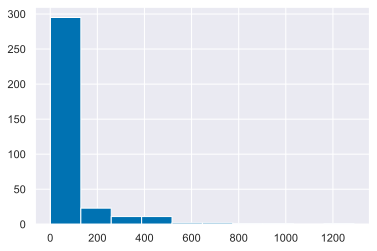

In [1740]:
blogs_df.unique_pageviews.hist()

In [1745]:
blogs_df.unique_pageviews.mean()
blogs_df.unique_pageviews.median()

59.18882978723404

7.0

## NMF topic modeling with countvectorizer ##

In [957]:
nmf_model = NMF(8, max_iter=400)
doc_topic = nmf_model.fit_transform(cv_doc_word)

In [958]:
doc_topic_df = pd.DataFrame(doc_topic.round(2))

In [959]:
topic_word_df = pd.DataFrame(nmf_model.components_.round(2),
                             columns=cv.get_feature_names())

In [960]:
words = topic_word_df.columns.to_list()

In [961]:
# Finding the top 7 words with the highest weights for each topic
indices_top_words = nmf_model.components_.argsort(axis=1)[:, -1:-8:-1]
top_topic_words = [[words[index] for index in indices_list] for indices_list in indices_top_words]

In [962]:
top_topic_words

[['gay', 'guy', 'friend', 'talk', 'body', 'start', 'meet'],
 ['passionate',
  'dream job',
  'fantasy',
  'change world',
  'world idea',
  'diversity',
  'follower'],
 ['live', 'parent', 'self', 'thought', 'fear', 'death', 'grow'],
 ['asian', 'identity', 'man', 'white', 'gay', 'word', 'american'],
 ['relationship', 'date', 'long', 'person', 'heart', 'distance', 'question'],
 ['new', 'day', 'family', 'tell', 'parent', 'ask', 'friend'],
 ['believe',
  'diaries',
  'gaysian diaries',
  'story',
  'gapimny',
  'past',
  'shape'],
 ['film', 'white', 'lgbtq', 'festival', 'gay', 'really', 'feel like']]

## Finding optimal k (number of topics) ##

In [343]:
# Trying to find the optimal k (i.e. the optimal number of topics)
from sklearn.utils.extmath import randomized_svd
u, sigma, v_t = randomized_svd(tfidf_doc_term.to_numpy(), 
                               n_components=15,
                               n_iter=5,
                               random_state=None)

In [344]:
sigma

array([5.49710071, 3.32968243, 2.11819461, 1.90838129, 1.7257528 ,
       1.6325004 , 1.57770707, 1.52068437, 1.50748865, 1.46953016,
       1.44599338, 1.40395299, 1.39046704, 1.36975005, 1.33509338])

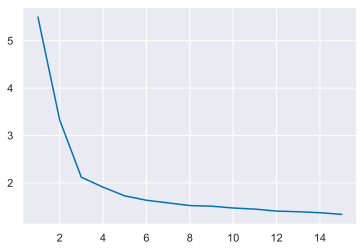

In [345]:
plt.plot(range(1,16), sigma)